# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Read in the temperature and humidity data set

In [23]:
df = pd.read_csv("train_humidity_temp.csv")

In [24]:
df.head()

,temp,humidity
0,9.84,81
1,9.02,80
2,9.02,80
3,9.84,75
4,9.84,75


# Function to scale the values for each feature in the DataFrame to a [0, 1] scale, considering the isotropic nature of K-Means clustering

In [11]:
# Maximum value of the 'temp' feature
max_temp = np.max(df['temp'])
# Minimum value of the 'temp' feature
min_temp = np.max(df['temp'])

# Maximum value of the 'humidity' feature
max_humid = np.max(df['humidity'])
# Minimum value of the 'humidity' feature
min_humid = np.min(df['humidity'])

print("The maximum temperature is: %s degrees celsius." % max_temp)
print("The minimum temperature is: %s degrees celsius." % min_temp)
print("The maximum humidity is: %s percent." % max_humid)
print("The minimum humidity is: %s percent." % min_humid)

The maximum temperature is: 41.0 degrees celsius.
The minimum temperature is: 41.0 degrees celsius.
The maximum humidity is: 100 percent.
The minimum humidity is: 0 percent.


In [27]:
def scale_my_values(row):
    # This is zero because the max - min value is zero
    # I simply assigned this to be zero to save on computations
    scaled_temp = 0
    
    # Denominator of the humidity feature
    denom_humidity = 100
    
    scaled_humidity = np.divide(
        row['humidity'] - min_humid,    # This is the numerator
        denom_humidity
    )
    
    return pd.Series([scaled_temp, scaled_humidity], index=['temp', 'humidity'])

In [28]:
scaled_df = df.apply(scale_my_values, axis=1)

In [29]:
scaled_df.head()

,temp,humidity
0,0.0,0.81
1,0.0,0.80
2,0.0,0.80
3,0.0,0.75
4,0.0,0.75


# Function to calculate the Euclidean distance between each data point and each centroid, and assign the data point to the closest cluster

In [4]:
def find_closest_centroid(row, centroids, centroid_to_row_num):
    closest_distance = 999999
    closest_centroid = 99
    
    for i, centroid_vector in enumerate(centroids):
        current_distance = np.sqrt(np.power((row['temp'] - centroid_vector[0]), 2) + np.power((row['humidity'] - centroid_vector[1]), 2))
        if (current_distance < closest_distance):
            closest_distance = current_distance
            closest_centroid = i
    
    centroid_to_row_num[closest_centroid].append((row['temp'], row['humidity']))
    
    return row

# Function to calculate the average within-cluster sum-of-squared error

In [30]:
def calc_within_cluster_sse(num_clusters):
    # Select num_clusters worth of random points to initialize as the centroid mean
    centroids = []
    for i in range(0, num_clusters):
        centroids.append((
            scaled_df.iloc[np.random.randint(0, scaled_df.shape[0])]['temp'], 
            scaled_df.iloc[np.random.randint(0, scaled_df.shape[0])]['humidity']
        ))
    
    # Initialize a dictionary of K lists to store the points that map to the closest centroid
    centroid_to_row_num = {}

    for each_cluster_index in range(0, num_clusters):
        centroid_to_row_num[each_cluster_index] = []
    
    # Assign the data points to the nearest cluster
    scaled_df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)
    
    # Calculate the average within-cluster sum-of-squared errors across all clusters
    avg_within_cluster_sse = 0
    for each_cluster_index in centroid_to_row_num:
        avg_within_cluster_sse += np.sum(
            np.sqrt(
                [(np.power(x[0] - centroids[each_cluster_index][0], 2) + np.power(x[1] - centroids[each_cluster_index][1], 2)) for x in centroid_to_row_num[each_cluster_index]]
            )
        )
    avg_within_cluster_sse /= len(centroids)
    
    return avg_within_cluster_sse
    

# Use the elbow method on the average sum-of-squared errors across clusters to find the optimal K for the number of clusters

In [31]:
num_clusters = 20

In [32]:
cluster_index_to_sse_dict = {}
for i in range(1, num_clusters + 1):
    cluster_index_to_sse_dict[i] = calc_within_cluster_sse(i)

In [33]:
cluster_index_to_sse_dict

{1: 1825.21,
 2: 487.58000000000004,
 3: 424.55,
 4: 196.67000000000002,
 5: 147.26000000000002,
 6: 105.68333333333332,
 7: 60.448571428571434,
 8: 46.28374999999999,
 9: 33.68222222222222,
 10: 28.73399999999999,
 11: 46.67999999999998,
 12: 33.321666666666665,
 13: 19.287692307692307,
 14: 20.155000000000005,
 15: 16.478666666666665,
 16: 26.408124999999995,
 17: 13.802941176470586,
 18: 16.054444444444442,
 19: 12.032105263157895,
 20: 12.761499999999995}

# Plot the sum-of-squared errors against the number of clusters

Text(0,0.5,'Sum-of-squared Errors')

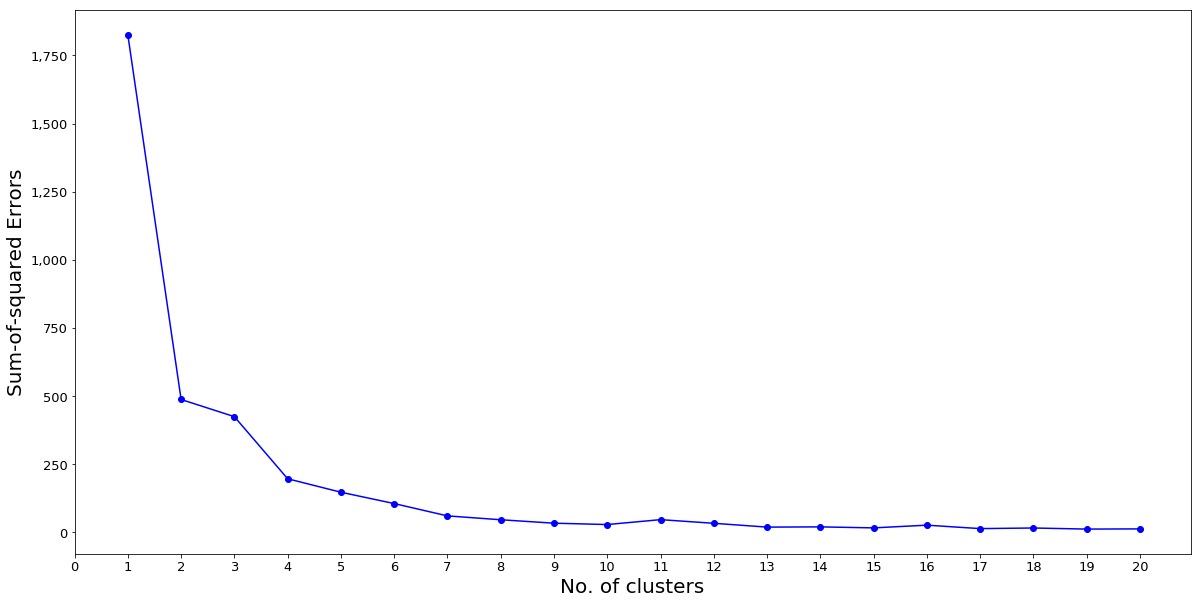

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(
    [x for x in cluster_index_to_sse_dict], 
    [cluster_index_to_sse_dict[x] for x in cluster_index_to_sse_dict], 
    'o', 
    color='blue',
    linestyle='-'
)
x_start, x_end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, num_clusters + 1, 1))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('No. of clusters', fontsize=20)
ax.set_ylabel('Sum-of-squared Errors', fontsize=20)

# Selecting K random data points to be the initial cluster centroids

In [36]:
num_clusters = 4

# The data points for the cluster centroids are in the form: (temp, humidity)

In [37]:
centroids = []
for i in range(0, num_clusters):
    centroids.append((
        scaled_df.iloc[np.random.randint(0, scaled_df.shape[0])]['temp'], 
        scaled_df.iloc[np.random.randint(0, scaled_df.shape[0])]['humidity']
    ))

In [38]:
centroids

[(0.0, 0.45), (0.0, 0.94), (0.0, 0.55), (0.0, 0.65)]

# Initialize a dictionary of K lists to store the points that map to the closest centroid

In [39]:
centroid_to_row_num = {}

for each_cluster_index in range(0, num_clusters):
    centroid_to_row_num[each_cluster_index] = []

In [40]:
scaled_df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)

,temp,humidity
0,0.0,0.81
1,0.0,0.80
2,0.0,0.80
3,0.0,0.75
4,0.0,0.75
5,0.0,0.75
6,0.0,0.80
7,0.0,0.86
8,0.0,0.75
9,0.0,0.76


# Plot the initial clusters and data points on a scatterplot

Text(0,0.5,'Humidity')

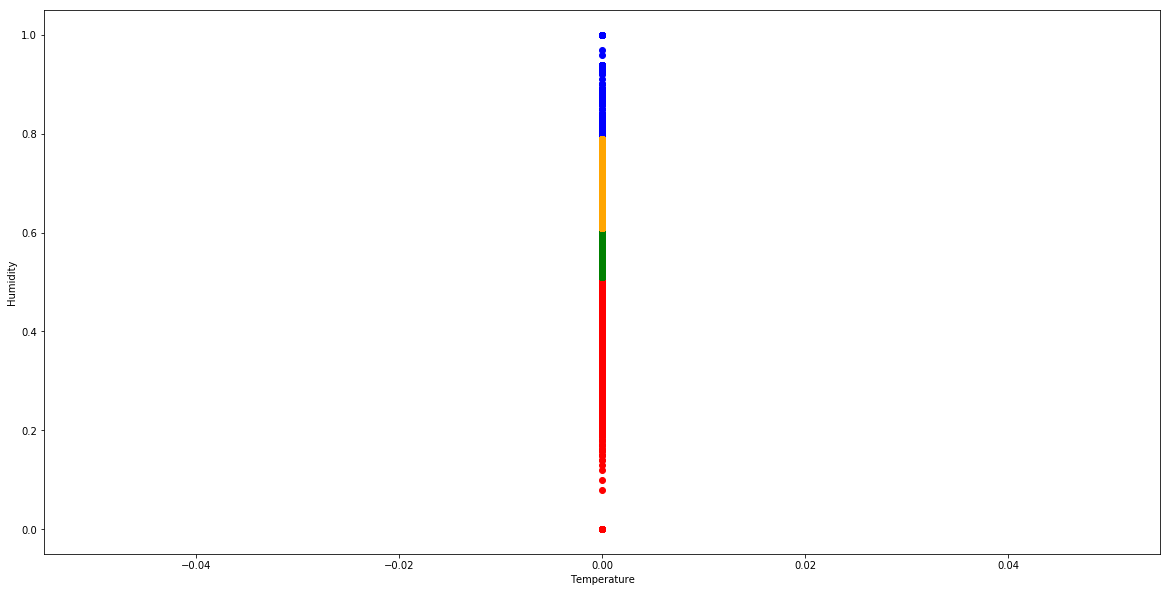

In [41]:
graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
fig, ax = plt.subplot(figsize=(20,10))
for i in range(0, num_clusters):
    ax.plot(
        [x[0] for x in centroid_to_row_num[i]], 
        [x[1] for x in centroid_to_row_num[i]], 
        'o', 
        color=graph_point_colors[i]
    )
ax.set_xlabel('Temperature', fontsize=20)
ax.set_ylabel('Humidity', fontsize=20)

# Calculate the new centroid means

In [42]:
for cluster_centroid_index in centroid_to_row_num:
    centroids[cluster_centroid_index] = (np.mean([x[0] for x in centroid_to_row_num[cluster_centroid_index]]), np.mean([x[1] for x in centroid_to_row_num[cluster_centroid_index]]))

In [43]:
centroids

[(0.0, 0.39346812278630466),
 (0.0, 0.8790055014811681),
 (0.0, 0.5538037486218301),
 (0.0, 0.6992805538832029)]

# Re-calculate the Euclidean distance between each point and the new cluster centroids

In [44]:
scaled_df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)

,temp,humidity
0,0.0,0.81
1,0.0,0.80
2,0.0,0.80
3,0.0,0.75
4,0.0,0.75
5,0.0,0.75
6,0.0,0.80
7,0.0,0.86
8,0.0,0.75
9,0.0,0.76


# Plot the new clusters and data points

Text(0,0.5,'Humidity')

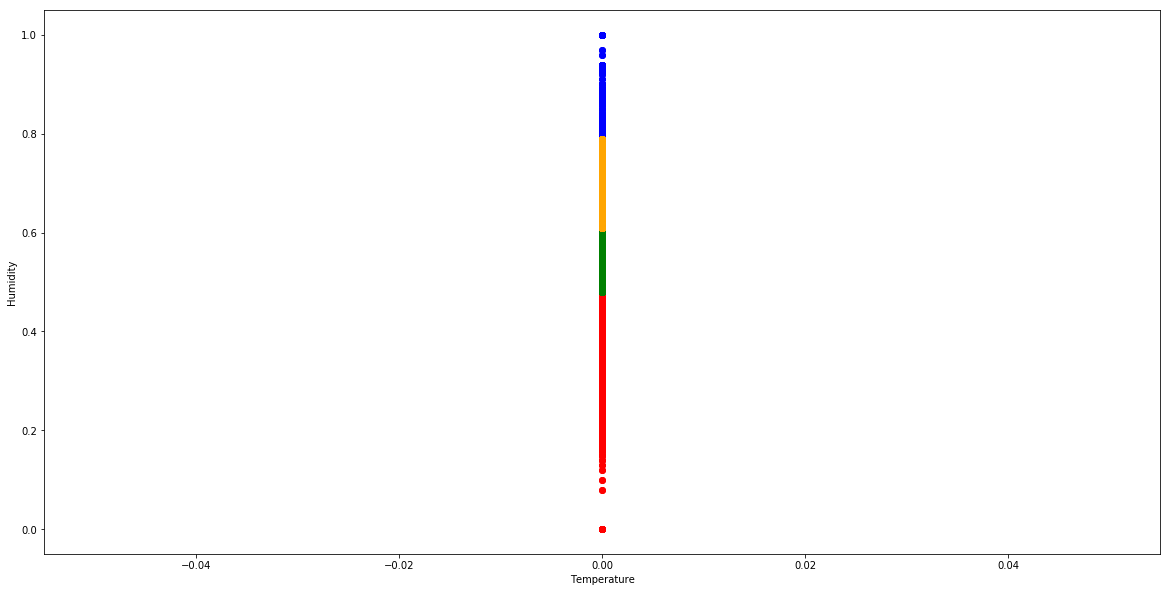

In [45]:
graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
fig, ax = plt.subplot(figsize=(20,10))
for i in range(0, num_clusters):
    ax.plot(
        [x[0] for x in centroid_to_row_num[i]], 
        [x[1] for x in centroid_to_row_num[i]], 
        'o', 
        color=graph_point_colors[i]
    )
ax.set_xlabel('Temperature', fontsize=20)
ax.set_ylabel('Humidity', fontsize=20)

# For the next 5 iterations, repeat the new centroid re-calculation, cluster grouping for each data point, and plot the adjusted clusters and data points

In [46]:
num_iterations = 100

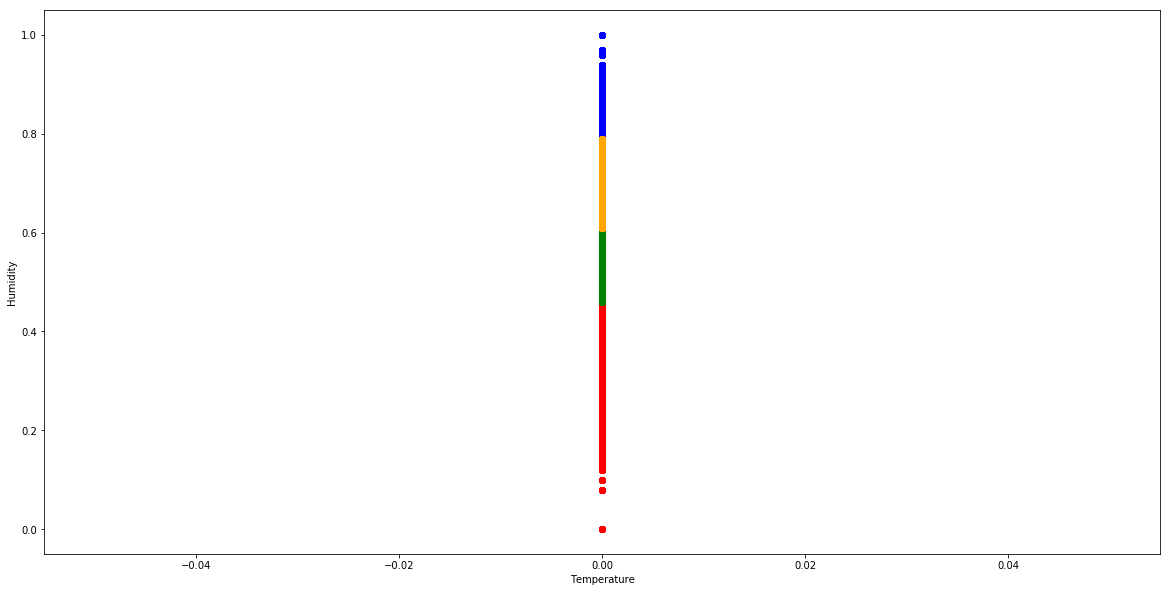

In [47]:
for i in range(0, num_iterations):
    # Re-calculate the new cluster centroid
    for cluster_centroid_index in centroid_to_row_num:
        centroids[cluster_centroid_index] = (np.mean([x[0] for x in centroid_to_row_num[cluster_centroid_index]]), np.mean([x[1] for x in centroid_to_row_num[cluster_centroid_index]]))
    
    # Re-calculate the distance between each point and the new cluster centroid,
    # assigning them a new cluster grouping if necessary
    scaled_df.apply(find_closest_centroid, args=(centroids, centroid_to_row_num,), axis=1)
    
    # Plot the new adjusted cluster(s) and data point(s)
#     graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
#     plt.figure(figsize=(20,10))
#     for i in range(0, num_clusters):
#         plt.plot([x[0] for x in centroid_to_row_num[i]], [x[1] for x in centroid_to_row_num[i]], 'o', color=graph_point_colors[i])
#     plt.xlabel('Temperature')
#     plt.ylabel('Humidity')

graph_point_colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'pink', 'black', 'plum', 'yellowgreen']
fig, ax = plt.subplot(figsize=(20,10))
for i in range(0, num_clusters):
    ax.plot(
        [x[0] for x in centroid_to_row_num[i]], 
        [x[1] for x in centroid_to_row_num[i]], 
        'o', 
        color=graph_point_colors[i]
    )
ax.set_xlabel('Temperature', fontsize=20)
ax.set_ylabel('Humidity', fontsize=20)